### Import Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats

import datetime as dt

### Reflect tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import os

In [3]:
# Create database connection
engine = create_engine(os.path.join("sqlite:///","Resources","hawaii.sqlite"))

In [4]:
# Declare a base and reflect an existing database into a new model
Base = automap_base()
# Use the base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

---
## __Exploratory Climate Analysis:__
---
## __I. Percipitation Analysis:__

In [8]:
# Inspect the measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


#### __Last 12 Months of Precipitation Data__

In [9]:
# find last data point for date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'The last date in the dataset is {latest_date}.')

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f'A year prior from the last date in the dataset is {year_ago}')

# Perform a query to retrieve the data and precipitation scores & save query results as a Pandas DataFrame
last_12_mos = pd.read_sql(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').statement, engine)
# print(last_12_mos)

# Set the index to the date column & sort the dataframe by date
last_12_mos = last_12_mos.set_index('date')
last_12_mos = last_12_mos.sort_values('date')
last_12_mos = last_12_mos.rename(columns={'prcp':'Precipitation'})
last_12_mos.head()

The last date in the dataset is ('2017-08-23',).
A year prior from the last date in the dataset is 2016-08-23


,Precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [10]:
# # explore dataframe and database for null values
# last_12_mos.isnull().any()
# last_12_mos_explore = pd.read_sql(session.query(Measurement.date, Measurement.prcp, Measurement.station, Measurement.tobs).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').statement, engine)
# last_12_mos_explore.loc[last_12_mos_explore.isnull().any(axis=1)]

# # the null values for prcp appear to be for stations that reported a tobs on that date but not a prcp
# # based on this, we can conclude that the null values for prcp in the 'last_12_mos' dataframe can be dropped for the precipitation analysis 
# last_12_mos = last_12_mos.dropna(how='any')
# last_12_mos = last_12_mos.rename(columns={'prcp':'Precipitation'})
# last_12_mos.head()
# last_12_mos['Precipitation'].max()

#### __Plot Last 12 Months of Precipitation Data__

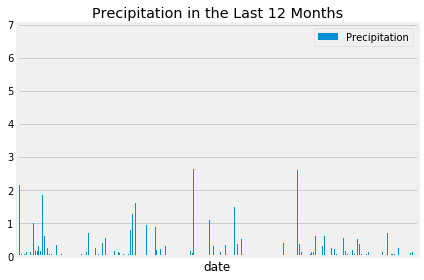

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
# last_12_mos.plot(kind="bar")
last_12_mos.plot.bar(rot=0)
plt.xticks([])
# plt.ylim(0,7)
plt.title("Precipitation in the Last 12 Months")
plt.tight_layout()

#### __Summary Statisitics for Precipitation Data__

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_mos.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## __II. Station Analysis:__

In [13]:
# Inspect the station table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


#### __Number of Available Stations in Dataset__

In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f'There are {station_count} stations in this dataset.')

There are 9 stations in this dataset.


#### __Stations in Descending Order by Activity__

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_frequency = session.query(Measurement.station, 
                                  func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# print(station_frequency)

# Join measurement and station table to get the names of each station
join=session.query(Measurement.station, Station.name, func.count(Measurement.station)).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
join

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

#### __Station with Highest Observations__

In [16]:
# Which station has the highest number of observations?
highest_obs = station_frequency[0][0]
highest_obs_name =  join[0][1]
print(f'The station with the highest number of observations is {highest_obs}, {highest_obs_name}.')

The station with the highest number of observations is USC00519281, WAIHEE 837.5, HI US.


#### __The Top Stations Lowest, Highest, & Average Temperature__

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == highest_obs).all()
print(f'Station {highest_obs} lowest recorded temperature: {low_temp}.')

high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == highest_obs).all()
print(f'Station {highest_obs} highest recorded temperature: {high_temp}.')

avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == highest_obs).all()
print(f'Station {highest_obs} average temperature: {avg_temp}.')

Station USC00519281 lowest recorded temperature: [(54.0,)].
Station USC00519281 highest recorded temperature: [(85.0,)].
Station USC00519281 average temperature: [(71.66378066378067,)].


#### __Last 12 Months of tobs Data for Top Station__

In [18]:
# HW instructions say to query last 12 months of tobs data,
# Then filter by Station with the highest number of tobs during 12 month frame
# top_tobs = session.query(Measurement.station, 
#                                   func.count(Measurement.tobs)).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

# Starter notebook says: Choose the station with the highest number of temperature observations,
# Then query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_12_mos = pd.read_sql(session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == highest_obs).filter(Measurement.date <= '2017-08-23').filter(Measurement.date >= '2016-08-23').statement, engine)
tobs_12_mos.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


#### __Plot Histogram of tobs for Top Station in Last 12 Months__

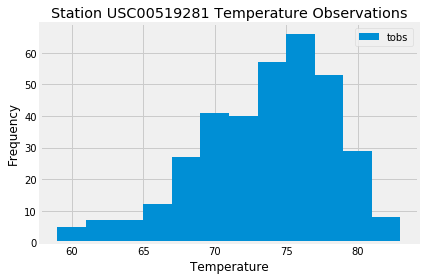

In [19]:
# Plot results for stations last 12 months tobs query as a histogram 
tobs_12_mos.hist(bins=12, label='tobs')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title(f'Station {highest_obs} Temperature Observations')
plt.legend()
plt.tight_layout()

---
## __Additional Analysis:__
---
## __I. Temperature Analysis I:__

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

In [20]:
dec_str = '12'
dec_avg_temp = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date)==dec_str).all()
print(f'The average temperature in December is {dec_avg_temp}.')

jun_str = '06'
jun_avg_temp = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date)==jun_str).all()
print(f'The average temperature in June is {jun_avg_temp}.')

The average temperature in December is [(71.04152933421226,)].
The average temperature in June is [(74.94411764705882,)].


I will now used an unpaired t-test (aka an Independent t-test) to determine whether the difference in the means is statistically significant. I am using an independent t-test because I am comparing the sample mean of two independent groups.

In [21]:
d_temps = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date)==dec_str).group_by(Measurement.station).all()
j_temps = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date)==jun_str).group_by(Measurement.station).all()
# print(d_temps)
# print(j_temps)

stats.ttest_ind(d_temps, j_temps)

Ttest_indResult(statistic=array([-4.61586542]), pvalue=array([0.00028626]))

## __II. Temperature Analysis II:__

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# My trip start date = 2019-12-27 and end date = 2020-01-03
# The matching dataset dates for my trip are: start date = 2016-12-27 and end date = 2017-01-03

print(calc_temps('2016-12-27', '2017-01-03'))
trip_results=calc_temps('2016-12-27', '2017-01-03')
trip_results

[(62.0, 70.20408163265306, 77.0)]


[(62.0, 70.20408163265306, 77.0)]

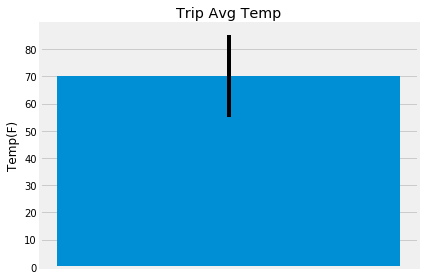

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip=trip_results[0]
y_value=trip[1]
std=trip[2]-trip[0]
x=1

plt.bar(x, y_value, yerr=std)
# plt.xlim(.8,1.2)
plt.xticks([])
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
plt.tight_layout()

## __III. Daily Rainfall Average:__

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_join=session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).filter(Measurement.station == Station.station).filter(Measurement.date>='2016-12-27').filter(Measurement.date<='2017-01-03').group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
rain_join

[(4.61,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (1.42, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (1.2500000000000002,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (1.24,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (0.19, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.18,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (None, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date=dt.date(2016,12,27)
end_date=dt.date(2017,1,3)

# Use the start and end date to create a range of dates
date_array=[]
for x in range(0, ((end_date-start_date).days)+1):
    ddate=start_date+dt.timedelta(days=x)
    date=ddate.strftime('%Y-%m-%d')
    date_array.append(date)
print(date_array)

# Strip off the year and save a list of %m-%d strings
date_array_strip=[]
for x in range(0, ((end_date-start_date).days)+1):
    strip_ddate=start_date+dt.timedelta(days=x)
    strip_date=strip_ddate.strftime('%m-%d')
    date_array_strip.append(strip_date)
date_array_strip

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for date in date_array_strip:
    daily_norm=daily_normals(date)
    normals.append(daily_norm)
    
normals

['2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31', '2017-01-01', '2017-01-02', '2017-01-03']


[[(62.0, 71.91666666666667, 79.0)],
 [(62.0, 70.52083333333333, 77.0)],
 [(57.0, 70.29166666666667, 78.0)],
 [(63.0, 69.86363636363636, 76.0)],
 [(56.0, 68.27906976744185, 77.0)],
 [(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)]]

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

tmin_list=[]
for x in normals:
    tmin=x[0][0]
    tmin_list.append(tmin)
tmin_list

tavg_list=[]
for x in normals:
    tavg=x[0][1]
    tavg_list.append(tavg)
tavg_list

tmax_list=[]
for x in normals:
    tmax=x[0][2]
    tmax_list.append(tmax)
tmax_list

df_dict={'Date':date_array, 'TMin':tmin_list, 'TAvg':tavg_list, 'TMax':tmax_list}
df_dict
    
df=pd.DataFrame(df_dict)
df=df.set_index('Date')
df

,TMin,TAvg,TMax
Date,,,
2016-12-27,62.0,71.916667,79.0
2016-12-28,62.0,70.520833,77.0
2016-12-29,57.0,70.291667,78.0
2016-12-30,63.0,69.863636,76.0
2016-12-31,56.0,68.279070,77.0
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0


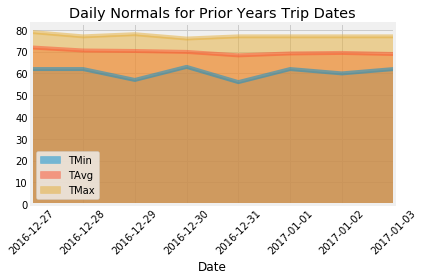

In [34]:
# Plot the daily normals as an area plot with `stacked=False`

df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.title('Daily Normals for Prior Years Trip Dates')
plt.tight_layout()